In [2]:
# If running on Colab, install dependencies
import sys, subprocess, os, torch
!pip -q install gensim spacy pandas scikit-learn matplotlib tqdm
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 146.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Imports and paths
import pandas as pd
import numpy as np
import spacy
from collections import Counter, defaultdict
from pathlib import Path
import pickle

ROOT = Path().resolve().parent
DATA = ROOT / "notebooks" / "data"
EMB_OUT = DATA / "w2v_300d_embedding_matrix.npy"
VOCAB_OUT = DATA / "vocab.pkl"

train_df = pd.read_csv(DATA / "trec_train.csv")
val_df   = pd.read_csv(DATA / "trec_val.csv")
test_df  = pd.read_csv(DATA / "trec_test.csv")

print(train_df.shape, val_df.shape, test_df.shape)


(4362, 2) (1090, 2) (500, 2)


# From Part 1

In [ ]:
# Load embedding and vocab
embedding_matrix = np.load(EMB_OUT)

with open(VOCAB_OUT, "rb") as f:
    vocab = pickle.load(f)
stoi = vocab['stoi']
itos = vocab['itos']

PAD_IDX, UNK_IDX = 0, 1
VOCAB_SIZE = len(itos)
EMBED_DIM = embedding_matrix.shape[1]

In [6]:
# Maps labels from string to index for modelling
label_map = {label: i for i, label in enumerate(sorted(train_df['label'].unique()))}

In [7]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])

def tokenize(text):
    doc = nlp(text)
    return [t.text.lower() for t in doc if not t.is_space]

# Part 2

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config init
HIDDEN_DIM = 128
DROPOUT = 0.0
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EMBEDDING_DIM = 300
N_LAYERS = 1
PAD_IDX = 0
UNK_IDX = 1
OUTPUT_DIM = 6

In [42]:
# Utils Helper
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn # Import nn module

from torch.nn.utils.rnn import pack_padded_sequence
# RNN Model
class RNNClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, pad_idx, n_layers, embedding_matrix, aggregration_strat='last', dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embedding_matrix).float(),freeze=False, padding_idx=pad_idx)
        self.rnn = nn.RNN(input_size=embedding_dim,hidden_size=hidden_dim,num_layers=n_layers,batch_first=True, dropout=dropout if n_layers > 1 else 0.0)

        self.embedding_dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.aggregation = aggregration_strat
        self.hidden_dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)

        lengths = (x != PAD_IDX).sum(dim=1).cpu()
        packed_seq = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_seq)

        # Sentence Aggregation
        if self.aggregation == 'last':
            last_hidden = hidden[-1]
        elif self.aggregation == 'mean':
            last_hidden = packed_output.mean(dim=1)
        elif self.aggregation == 'max':
            last_hidden = torch.max(packed_output,dim=1)

        # last_hidden = hidden[-1]

        last_hidden = self.hidden_dropout(last_hidden)
        logits = self.fc(last_hidden)
        return logits


class txtDataset(Dataset):
    def __init__(self, df, stoi,label_map):
        self.texts = df['text'].tolist()
        self.labels = df['label'].map(label_map).tolist()
        self.stoi = stoi

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        indices = [self.stoi.get(token, UNK_IDX) for token in tokenize(text)]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    text,labels = zip(*batch)
    text_padding = pad_sequence(text,batch_first=True,padding_value=PAD_IDX)
    labels = torch.stack(labels)
    return text_padding,labels


# Training and Test Loop
def train_loop(train_dataloader,model,criterion,optimizer):
    model.train()
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    train_loss, train_correct = 0,0
    for batch, (X,y) in enumerate (train_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred,y)
        loss.backward()
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        optimizer.step()

    train_loss /= num_batches
    train_correct /=size

    return train_loss, train_correct

def test(test_dataloader,model,criterion):
    model.eval()
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    val_loss, val_correct = 0,0
    with torch.no_grad():
        for batch, (X,y) in enumerate (test_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += criterion(pred,y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= num_batches
        val_correct /=size

    return val_loss, val_correct

# Model Training
def train(train_dataloader,val_dataloader,model,criterion,optimizer,epochs = EPOCHS, patience=7):
    train_acc_, val_acc_, train_loss_, val_loss_ = [], [], [], []
    best_val_acc = 0
    epochs_no_improve = 0

    for i in range(epochs):
        train_loss, train_acc = train_loop(train_dataloader,model,criterion,optimizer)
        val_loss, val_acc = test(val_dataloader,model,criterion)

        train_acc_.append(train_acc)
        val_acc_.append(val_acc)
        train_loss_.append(train_loss)
        val_loss_.append(val_loss)

        print(f"Epoch {i+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping after {i+1} epochs due to no improvement in validation accuracy.")
                break

    return train_acc_, val_acc_, train_loss_, val_loss_

# Plotting
import matplotlib.pyplot as plt
def plot(train_acc_,val_acc_,train_loss_,val_loss_):
    # Loss Plot
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_loss_)+1), train_loss_, label="Train Loss")
    plt.plot(range(1, len(val_loss_)+1), val_loss_, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.show()

    # Accuracy Plot
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_acc_)+1), train_acc_, label="Train Accuracy")
    plt.plot(range(1, len(val_acc_)+1), val_acc_, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.show()

Epoch 1/50 | Train Loss: 1.4727 | Train Acc: 0.3629 | Val Loss: 1.2248 | Val Acc: 0.4872
Epoch 2/50 | Train Loss: 0.8165 | Train Acc: 0.7111 | Val Loss: 0.8544 | Val Acc: 0.6954
Epoch 3/50 | Train Loss: 0.4106 | Train Acc: 0.8751 | Val Loss: 0.5548 | Val Acc: 0.8229
Epoch 4/50 | Train Loss: 0.2322 | Train Acc: 0.9303 | Val Loss: 0.5903 | Val Acc: 0.8174
Epoch 5/50 | Train Loss: 0.2125 | Train Acc: 0.9415 | Val Loss: 0.6218 | Val Acc: 0.8000
Epoch 6/50 | Train Loss: 0.2161 | Train Acc: 0.9340 | Val Loss: 0.7144 | Val Acc: 0.7899
Epoch 7/50 | Train Loss: 0.1287 | Train Acc: 0.9640 | Val Loss: 0.5868 | Val Acc: 0.8349
Epoch 8/50 | Train Loss: 0.0450 | Train Acc: 0.9904 | Val Loss: 0.5249 | Val Acc: 0.8596
Epoch 9/50 | Train Loss: 0.0201 | Train Acc: 0.9966 | Val Loss: 0.5248 | Val Acc: 0.8606
Epoch 10/50 | Train Loss: 0.0113 | Train Acc: 0.9991 | Val Loss: 0.5420 | Val Acc: 0.8661
Epoch 11/50 | Train Loss: 0.0075 | Train Acc: 0.9995 | Val Loss: 0.5708 | Val Acc: 0.8651
Epoch 12/50 | Train

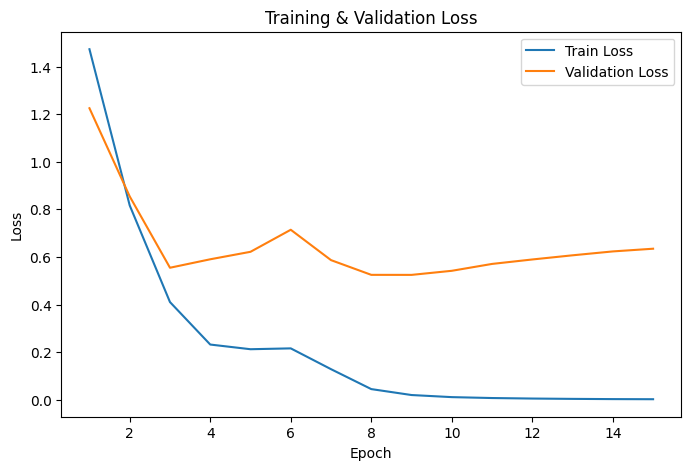

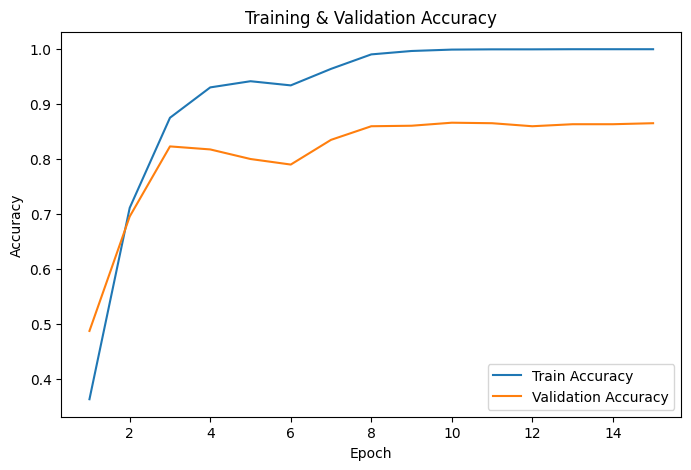

In [ ]:
# Main
train_data = txtDataset(train_df,stoi,label_map)
val_data = txtDataset(val_df, stoi,label_map)
test_data = txtDataset(test_df, stoi,label_map)

train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
val_dataloader = DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

model = RNNClassifier(EMBEDDING_DIM,HIDDEN_DIM,OUTPUT_DIM,PAD_IDX,N_LAYERS,embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
train_acc_, val_acc_, train_loss_, val_loss_ = train(train_dataloader,val_dataloader,model,criterion,optimizer)
plot(train_acc_, val_acc_, train_loss_, val_loss_)

### 2-(a). Configuration of the best model

In [10]:
HIDDEN_DIMS = [128, 256]
LEARNING_RATES = [1e-3, 5e-4]
BATCH_SIZES = [32, 64]
OPTIMIZERS = ['Adam', 'SGD']
DROPOUT_FIXED = 0


In [13]:
best_config = None
best_val_acc = 0.0

EPOCHS = 50

for hidden_dim in HIDDEN_DIMS:
    for lr in LEARNING_RATES:
        for batch_size in BATCH_SIZES:
            for opt_name in OPTIMIZERS:
                print("__________________________________________________")
                print(f"Testing: hidden={hidden_dim}, lr={lr}, batch={batch_size}, opt={opt_name}")

                # Dataloader
                train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
                val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

                # Model
                model = RNNClassifier(
                    EMBEDDING_DIM, hidden_dim, OUTPUT_DIM, PAD_IDX, N_LAYERS,
                    embedding_matrix, dropout=DROPOUT
                ).to(device)

                criterion = nn.CrossEntropyLoss()
                optimizer = (
                    torch.optim.Adam(model.parameters(), lr=lr)
                    if opt_name == 'Adam'
                    else torch.optim.SGD(model.parameters(), lr=lr)
                )

                # Train
                _, val_acc_, _, _ = train(
                    train_dataloader, val_dataloader, model,
                    criterion, optimizer, epochs=EPOCHS, patience=10
                )

                # Update best hyperparam
                if max(val_acc_) > best_val_acc:
                    best_val_acc = max(val_acc_)
                    best_config = {
                        'hidden_dim': hidden_dim,
                        'lr': lr,
                        'batch_size': batch_size,
                        'optimizer': opt_name
                    }

print("\n Best Config :", best_config, "| Val Accuracy :", round(best_val_acc, 4))

__________________________________________________
Testing: hidden=128, lr=0.001, batch=32, opt=Adam
Epoch 1/50 | Train Loss: 1.3323 | Train Acc: 0.4427 | Val Loss: 0.9025 | Val Acc: 0.6872
Epoch 2/50 | Train Loss: 0.5553 | Train Acc: 0.8223 | Val Loss: 0.5287 | Val Acc: 0.8303
Epoch 3/50 | Train Loss: 0.4168 | Train Acc: 0.8801 | Val Loss: 0.6259 | Val Acc: 0.8165
Epoch 4/50 | Train Loss: 0.1667 | Train Acc: 0.9558 | Val Loss: 0.5313 | Val Acc: 0.8431
Epoch 5/50 | Train Loss: 0.0930 | Train Acc: 0.9746 | Val Loss: 0.6048 | Val Acc: 0.8349
Epoch 6/50 | Train Loss: 0.0674 | Train Acc: 0.9840 | Val Loss: 0.7499 | Val Acc: 0.8220
Epoch 7/50 | Train Loss: 0.2390 | Train Acc: 0.9312 | Val Loss: 0.8037 | Val Acc: 0.7716
Epoch 8/50 | Train Loss: 0.0838 | Train Acc: 0.9766 | Val Loss: 1.0132 | Val Acc: 0.7358
Epoch 9/50 | Train Loss: 0.0503 | Train Acc: 0.9883 | Val Loss: 0.7983 | Val Acc: 0.8073
Epoch 10/50 | Train Loss: 0.0276 | Train Acc: 0.9940 | Val Loss: 0.7655 | Val Acc: 0.8220
Epoch 11

### 2-(b). Regularization strategies

In [21]:
HIDDEN_DIM = 256
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
OPTIMIZER = 'Adam'

#Regularization
DROPOUT_VALUES = [0.1, 0.3]
L2_VALUES = [5e-5, 1e-5]
USE_BATCHNORM = [False, True]

best_reg_results = {}
best_val_acc = 0.0
best_config = None

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

for dropout in DROPOUT_VALUES:
    for l2 in L2_VALUES:
        for use_bn in USE_BATCHNORM:
            reg_name = f"dropout: {dropout}, l2: {l2}, batchnorm: {use_bn}"
            print("_________________________________________________________")
            print(f"\nRegularization: {reg_name}")

            model = RNNClassifier( EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX, N_LAYERS,
                embedding_matrix, dropout=dropout).to(device)

            if use_bn:
                model.batch_norm = nn.BatchNorm1d(HIDDEN_DIM)
            else:
                model.batch_norm = nn.Identity()

            criterion = nn.CrossEntropyLoss()

            if OPTIMIZER == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=l2)
            else:
                optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=l2)

            _, val_acc_, _, _ = train(train_dataloader, val_dataloader, model, criterion, optimizer, epochs=50, patience=10)

            val_best = max(val_acc_)
            best_reg_results[reg_name] = val_best

            if val_best > best_val_acc:
                best_val_acc = val_best
                best_config = (dropout, l2, use_bn, model.state_dict())

            print(f"{reg_name} - Max Validation Accuracy: {val_best:.4f}")

print("\nFinal Regularization Combination Comparison")
for k, v in best_reg_results.items():
    print(f"{k} -> {v:.4f}")

best_dropout, best_l2, best_bn, best_weights = best_config
best_model = RNNClassifier(
    EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX, N_LAYERS,
    embedding_matrix, dropout=best_dropout
).to(device)
best_model.load_state_dict(best_weights)

if best_bn:
    best_model.batch_norm = nn.BatchNorm1d(HIDDEN_DIM)
else:
    best_model.batch_norm = nn.Identity()

criterion = nn.CrossEntropyLoss()
test_loss, test_acc = test(test_dataloader, best_model, criterion)
print(f"\n Best Model Test Accuracy: {test_acc:.4f}")


_________________________________________________________

Regularization: dropout: 0.1, l2: 5e-05, batchnorm: False
Epoch 1/50 | Train Loss: 1.5257 | Train Acc: 0.3510 | Val Loss: 1.3267 | Val Acc: 0.4596
Epoch 2/50 | Train Loss: 0.9743 | Train Acc: 0.6463 | Val Loss: 0.9623 | Val Acc: 0.6606
Epoch 3/50 | Train Loss: 0.5983 | Train Acc: 0.8161 | Val Loss: 0.8805 | Val Acc: 0.7477
Epoch 4/50 | Train Loss: 0.4167 | Train Acc: 0.8732 | Val Loss: 0.6438 | Val Acc: 0.8193
Epoch 5/50 | Train Loss: 0.2912 | Train Acc: 0.9140 | Val Loss: 0.6909 | Val Acc: 0.8266
Epoch 6/50 | Train Loss: 0.2457 | Train Acc: 0.9292 | Val Loss: 0.4587 | Val Acc: 0.8596
Epoch 7/50 | Train Loss: 0.2023 | Train Acc: 0.9413 | Val Loss: 0.6295 | Val Acc: 0.8211
Epoch 8/50 | Train Loss: 0.1489 | Train Acc: 0.9606 | Val Loss: 0.4395 | Val Acc: 0.8761
Epoch 9/50 | Train Loss: 0.0948 | Train Acc: 0.9764 | Val Loss: 0.5144 | Val Acc: 0.8596
Epoch 10/50 | Train Loss: 0.0866 | Train Acc: 0.9803 | Val Loss: 0.5431 | Val Acc:

Best regularization - dropout: 0.3 / l2: 5e-05 / batchnorm: False

In [ ]:
# Test accuracy without regularization
baseline_model = RNNClassifier(
    EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX, N_LAYERS,
    embedding_matrix, dropout=0.0).to(device)
baseline_model.batch_norm = nn.Identity()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)

_, val_acc_, _, _ = train(train_dataloader, val_dataloader, baseline_model, criterion, optimizer, epochs=50, patience=10)
baseline_loss, baseline_acc = test(test_dataloader, baseline_model, criterion)

print(f"\n Baseline (No Regularization) Test Accuracy: {baseline_acc:.4f}")

### 2-(c). Training curve


In [32]:
EPOCHS = 50
PATIENCE = 10
HIDDEN_DIM = 256
LR = 0.0005
DROPOUT = 0.3
WEIGHT_DECAY = 5e-5
USE_BATCHNORM = False

Epoch 1/50 | Train Loss: 1.5770 | Train Acc: 0.3155 | Val Loss: 1.2848 | Val Acc: 0.4991
Epoch 2/50 | Train Loss: 1.0459 | Train Acc: 0.6142 | Val Loss: 0.7463 | Val Acc: 0.7459
Epoch 3/50 | Train Loss: 0.6129 | Train Acc: 0.7964 | Val Loss: 0.5698 | Val Acc: 0.7972
Epoch 4/50 | Train Loss: 0.4452 | Train Acc: 0.8540 | Val Loss: 0.4901 | Val Acc: 0.8385
Epoch 5/50 | Train Loss: 0.3287 | Train Acc: 0.9003 | Val Loss: 0.4124 | Val Acc: 0.8661
Epoch 6/50 | Train Loss: 0.3239 | Train Acc: 0.9003 | Val Loss: 0.4593 | Val Acc: 0.8505
Epoch 7/50 | Train Loss: 0.1845 | Train Acc: 0.9459 | Val Loss: 0.4666 | Val Acc: 0.8404
Epoch 8/50 | Train Loss: 0.1838 | Train Acc: 0.9450 | Val Loss: 0.3874 | Val Acc: 0.8697
Epoch 9/50 | Train Loss: 0.1159 | Train Acc: 0.9686 | Val Loss: 0.4203 | Val Acc: 0.8633
Epoch 10/50 | Train Loss: 0.0844 | Train Acc: 0.9757 | Val Loss: 0.3984 | Val Acc: 0.8752
Epoch 11/50 | Train Loss: 0.0715 | Train Acc: 0.9787 | Val Loss: 0.4618 | Val Acc: 0.8633
Epoch 12/50 | Train

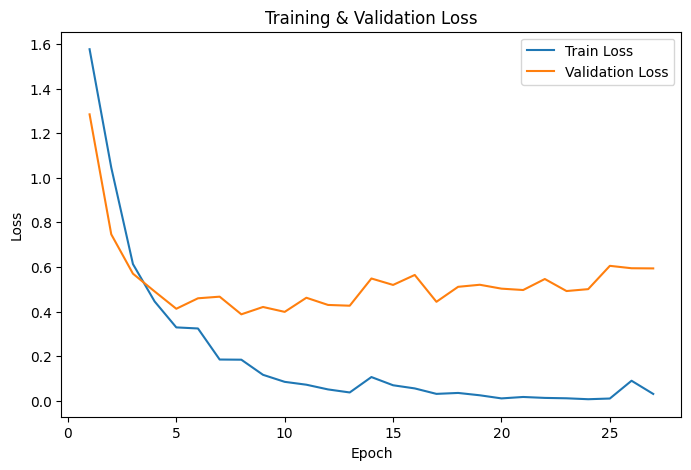

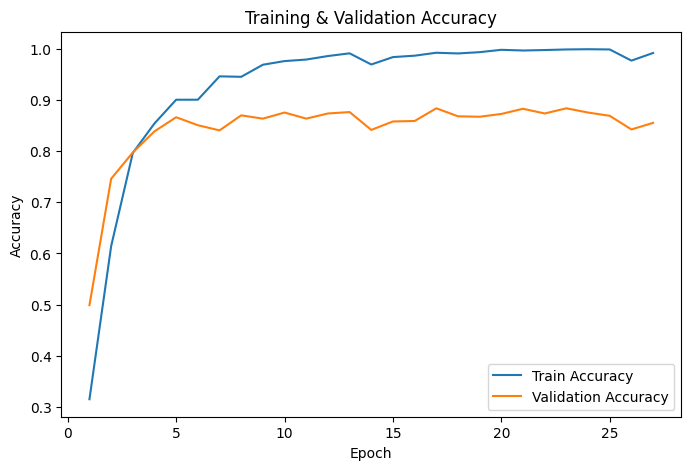

In [33]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False, collate_fn=collate_fn)

model = RNNClassifier(
    EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX, N_LAYERS,
    embedding_matrix, dropout=DROPOUT).to(device)

if USE_BATCHNORM:
    model.batch_norm = nn.BatchNorm1d(HIDDEN_DIM)
else:
    model.batch_norm = nn.Identity()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

train_acc_, val_acc_, train_loss_, val_loss_ = train(train_dataloader, val_dataloader, model, criterion, optimizer, epochs=EPOCHS, patience=PATIENCE)

plot(train_acc_, val_acc_, train_loss_, val_loss_)


### 2-(d).

In [56]:
# Compare different sentence representation strategies ('last', 'mean', 'max') for test accuracy

aggregation_strategies = ['last', 'mean', 'max']
agg_results = {}

for strat in aggregation_strategies:
    print(f"\n Aggregation Strategy: {strat} ")

    model = RNNClassifier(
        EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX, N_LAYERS,
        embedding_matrix, aggregration_strat=strat, dropout=DROPOUT
    ).to(device)

    if USE_BATCHNORM:
        model.batch_norm = nn.BatchNorm1d(HIDDEN_DIM)
    else:
        model.batch_norm = nn.Identity()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    train_acc_, val_acc_, train_loss_, val_loss_ = train(
        train_dataloader, val_dataloader, model, criterion, optimizer,
        epochs=EPOCHS, patience=PATIENCE)

    test_loss, test_acc = test(test_dataloader, model, criterion)
    agg_results[strat] = {'val_acc': max(val_acc_), 'test_acc': test_acc}

    print(f"Validation Accuracy: {max(val_acc_):.4f} | Test Accuracy: {test_acc:.4f}")

print("\n Final Aggregation Strategy Comparison")
for strat, result in agg_results.items():
    print(f"{strat:10s} | Val Acc: {result['val_acc']:.4f} | Test Acc: {result['test_acc']:.4f}")


 Aggregation Strategy: last 
Epoch 1/50 | Train Loss: 1.5860 | Train Acc: 0.3035 | Val Loss: 1.3524 | Val Acc: 0.5294
Epoch 2/50 | Train Loss: 1.0078 | Train Acc: 0.6339 | Val Loss: 0.7038 | Val Acc: 0.7550
Epoch 3/50 | Train Loss: 0.6725 | Train Acc: 0.7705 | Val Loss: 0.6255 | Val Acc: 0.7936
Epoch 4/50 | Train Loss: 0.4571 | Train Acc: 0.8519 | Val Loss: 0.5136 | Val Acc: 0.8257
Epoch 5/50 | Train Loss: 0.3340 | Train Acc: 0.8948 | Val Loss: 0.4090 | Val Acc: 0.8688
Epoch 6/50 | Train Loss: 0.2717 | Train Acc: 0.9182 | Val Loss: 0.6253 | Val Acc: 0.7771
Epoch 7/50 | Train Loss: 0.2392 | Train Acc: 0.9255 | Val Loss: 0.4500 | Val Acc: 0.8532
Epoch 8/50 | Train Loss: 0.1487 | Train Acc: 0.9548 | Val Loss: 0.4618 | Val Acc: 0.8514
Epoch 9/50 | Train Loss: 0.1162 | Train Acc: 0.9695 | Val Loss: 0.5646 | Val Acc: 0.8404
Epoch 10/50 | Train Loss: 0.2013 | Train Acc: 0.9404 | Val Loss: 0.4243 | Val Acc: 0.8688
Epoch 11/50 | Train Loss: 0.1016 | Train Acc: 0.9713 | Val Loss: 0.5726 | Val A

### 2-(e). Topic-wise accuracy

In [57]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

inv_label_map = {v: k for k, v in label_map.items()}

unique_labels = np.unique(all_labels)
topic_acc = {}

for lbl in unique_labels:
    idx = (all_labels == lbl)
    acc = accuracy_score(all_labels[idx], all_preds[idx])
    topic_acc[inv_label_map[lbl]] = acc

print("\n Topic wise Test Accuracy ")
for k, v in topic_acc.items():
    print(f"{k:10s} : {v:.4f}")

overall_acc = accuracy_score(all_labels, all_preds)
print(f"\n Overall Test Accuracy: {overall_acc:.4f}")


 Topic wise Test Accuracy 
ABBR       : 0.7778
DESC       : 0.9855
ENTY       : 0.6596
HUM        : 0.8923
LOC        : 0.8765
NUM        : 0.9027

 Overall Test Accuracy: 0.8720
